# Depth analysis <img align="right" src="../../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with the `NCI` and `DEA Sandbox` environment 
* **Products used:** 
* **Special requirements:** 
* **Prerequisites:** This notebook assumes you have previously run the [WetlandWaterDepthAnalyses.ipynb](./WetlandWaterDepthAnalyses.ipynb) notebook and saved out a netCDF file containing all the variables at the end of the notebook. A csv file containing the daily maximum water discharge of a relevant stream gauge is also required. The gauge data can be downloaded via the Bureau of Meteorology's [Water Data Online](http://www.bom.gov.au/waterdata/) portal.

## Background
The Commonwealth Environmental Water Office (CEWO) is obliged to act in accordance with the Water Act and the Basin Plan.  This requires Basin water resources to be managed in a way that gives effect to relevant international agreements (to the extent to which those agreements are relevant to the use and management of the Basin water resources). The Basin Plan has a specific objective to protect and restore a subset of all water-dependent ecosystems of the Murray-Darling Bain including by ensuring that: 
* Declared Ramsar wetlands that depend on Basin water resources maintain their ecological character. 

## Description
This notebook produces the following deliverables for each Ramsar site for each 10 year time period: 

* Maps in the form of .jpg, polygons and rasters showing: (these maps should also include key vegetation types, including open water, as provided by the CEWO and also the Ramsar site boundary.)
    1. Inundation extent for each month across the time period. (This could be presented so that you can slide along a hydrograph and see the resultant inundation extent on a map below. This should also identify key vegetation types. 
    2. Inundation extent for each vegetation type for each event (an event comprises the time between commencement of inundation of the vegetation type and conclusion of inundation of the vegetation type i.e. vegetation type completely dry) across the period event for critical durations (1, 3, 5, 7, >9 months)(these inundation extents are critical for different types of vegetation) 
        * Derived from remote sensing <img align='right' src="./InputData/TOR-AttachmentA.png" style="width: 400px;"/>
        2.a. Comparison of remotely sensed data with ground-truthed data and OEH datasets (NSW only). 
    3. Maps of depth for critical durations, only if DEM data is available within GA or supplied by CEWO (1, 3, 5, 7, >9 months)  
    4. Vegetation condition over the entire four year period. 
5. Graph and .csv file of inundation duration for each different vegetation type, for all natural and environmental flows, as per image to the right
6. Table identifying: 
    * % of different vegetation classes inundated for each specified time period for each event and maximum and average depth of inundation.
    * Time between each inundation event for 10%, 25%, 50%, 75% and 100% of each vegetation type 
e.g. 

| Site | Sub-site | Decade | Vegetation Type | % inundated 1 month | % inundated 3 months | % inundated 5 months | % inundated 7 months | % inundated > 9 months | Max depth | Average depth |
|-----|----|----|----|----|----|----|----|----|----|----|
|Banrock Station | | |River redgum | | | | | | |
| | | |Black box | | | | | | |
| | | |Lignum| | | | | | |
| | | |Saltmarsh| | | | | | |
| | | |Tall emergent aquatics| | | | | | |
| | | |Grass/forb | | | | | | |


7. Annual vegetation condition for each Ramsar site for the whole archive period
***

## Code assumptions

A few assumptions and decisions were made within the code that affect the outcome of the results:
1. Maps of inundation extent across the time period 2014-2019
2. Maps of inundation extent for each vegetation type for each event
    a. Comparison of remotely sensed data maps with ground-truthed data and OEH datasets 
3. Maps of depth for critical durations
4. Vegetation condition over the entire four year period
5. Graph and .csv file of inundation duration for each different vegetation type
6. Table identifying % of different vegetation classes inundated for each specified time period for each event and maximum and average depth of inundation and Time between each inundation event for 10%, 25%, 50%, 75% and 100% of each vegetation type
    - Events were defined as starting when at least `EventThreshold`(defined below)% of the total wetland area is seen as wet, and ends when no more than `EventThreshold`% of the wetland remains 'wet'. 
    - If the first time a wetland is observed by Landsat 5 (1986/7), the wetland meets the event threshold, we choose NOT to include this event in the list of events
        - We don't know how long the wetland was wet before we first observed it, and so can't provide uncertainties on event duration, so we do not include it in the results
    - For analysis of inundation WITHIN an event, we assume that if a single pixels wets, dries, wets etc more than once, it's all related to the same wetland-wide event (which is defined above). e.g. If a pixel has a within event inundation history of 5 days wet, then is dry for 5 days, then wet for 45 days, then we consider this pixel to have been wet for 50 days during this event. 
    - We use days to define the requested metric periods, so 1 month = 30 days, 3 months = 90 days etc.
    - Metrics for wet percentage for the 30, 90, 150, 210 and 270 day periods are calculated using >= each period. For example, a pixel that was wet for 110 days during an event will be counted in the 30 and 90 day metrics, but not the 150 day metric. 
    - Results for the duration of different percentages of inundation are presented in days. 
7. Annual vegetation condition for each Ramsar site for the whole archive period

## (Progress tracking)

| Wetland | LiDAR DEM | Vegetation shapefile | NetCDF created? | 
|---------|-----------|----------------------|-----------------|
| Narran Lake | <ul><li>Data are a combination of [GA's aggregated 5m DEM product](https://ecat.ga.gov.au/geonetwork/srv/eng/catalog.search#/metadata/89644), and NSW Spatial Services 5m DEM scenes from the couple of bits of the eastern edge of the Ramsar polygon that are cut out of the GA product</li><li>The combination happened by clipping the GA and required additional NSW scenes to the extent of the Ramsar polygon.</li><li> These were then merged together using the `mosaic` tool in ArcGIS, where the GA scene was given preference over the NSW scenes where data existed in both</li></ul>  | `VegShapeFileVegNameColumn = 'AggCOMM'` `VegShapeFileVegNameUIDColumn = None` | Yes |

***

## Getting started

Provide any particular instructions that the user might need, e.g. To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. 
Begin with any `iPython` magic commands, followed by standard Python packages, then any additional functionality you need from the `Scripts` directory.

In [81]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

import sys
import glob
import itertools
import xarray as xr
import numpy as np
import pandas as pd
from rasterio import features, transform, mask
import geopandas as gpd
from shapely.geometry import shape as shapelyshape
from scipy.interpolate import griddata

sys.path.append('../../Scripts')
from dea_spatialtools import interpolate_2d

import pickle

### Analysis parameters

* `AnalysisLocation`: A string descriptor of the analysis region used to label graphs.
* `StreamGaugeName`: A string name of the stream gauge used in the analysis, used to label graphs.
* `OutSaveLocation`: A string folder structure for the location of files written out by the [WetlandWaterDepthAnalyses.ipynb](./WetlandWaterDepthAnalyses.ipynb) notebook, and this notebook. It makes use of the `AnalysisLocation` string to generate the filepath.

#### Files to analyse
* `DatasetToLoad`: The filename of the netCDF written out by the [first notebook](./WetlandWaterDepthAnalyses.ipynb) to read in here. Note that this file must have been written out by the first notebook, as we assume the variables created in that notebook exist here. If you try to read in something else, this code will fail.
* `SpeciesDictToLoad`: The filename of the text file written out by the [first notebook](./WetlandWaterDepthAnalyses.ipynb) that contains the species dictionary of vegetation type and numerical ID. This is used to label plots.
* `StreamGaugeToLoad`: The filename of a csv file containing the daily maximum water discharge of a relevant stream gauge. The gauge data can be downloaded via the Bureau of Meteorology's [Water Data Online](http://www.bom.gov.au/waterdata/) portal. The code below assumes that commented lines begin with `#`. 

#### Analysis options
* `EventThreshold`: e.g. 5. Used to determine the threshold for starting/ending a watering event. Watering events are defined as starting when at least `EventThreshold`(defined below)% of the total wetland area is seen as wet, and ends when no more than `EventThreshold`% of the wetland remains 'wet'. If the wetland completely dries out between events, set this threshold low e.g. 5. If the wetland contains refugial pools that rarely dry out, a wet event may need to be defined using a higher threshold. 
* `AreasToCalc`: e.g. [0.1, 0.25, 0.50, 0.75, 0.100]. A list of numbers of the decimal vegetation area thresholds to calculate. E.g. 0.1 will calculate a value for 10% of the vegetation area. These are used in section 6 below.
* `Colormaps`: e.g. ['Blues', 'YlOrBr', 'Greens', 'Purples', 'Reds']. A list of [Matplotlib named colormaps](https://matplotlib.org/3.2.1/tutorials/colors/colormaps.html) to use to plot the different vegetation communities. 

#### Output filenames

##### Section 2
* `EventMapsFileName` : e.g. string. File path for the output plots for each wet event. The complete file path is created in the code below, since it adds in the event dates as it plots. 

##### Section 5
* `InundationPctPerVegFigFileName`: e.g. string.jpg Output file name for the all time vegetation community based inundation plot.
* `InundationPctPerVegDataFileName`: e.g. string.csv Output file name for the all time vegetation community based inundation csv.

##### Section 6
* `EventListFileName`: e.g. string.csv Output file name for the start and end dates and duration of each defined watering event.
* `EventInundationTableFileName`: e.g. string.csv Output file name for the event-based inundation % metrics for each vegetation community.
* `EventDurationTableFileName` : e.g. string.csv Output file name for the event-based duration metrics for each vegetation community.

In [2]:
# Note, if your `AnalysisLocation` contains special characters other than spaces, you will
# need to modify the `replace` function used to generate the output file names.
AnalysisLocation = 'Narran Lake'
StreamGaugeName = 'Wilby Wilby'
OutSaveLocation = f'OutputData/{AnalysisLocation.replace(" ", "")}/'

DatasetToLoad = f'{OutSaveLocation}AllDataCombined{AnalysisLocation.replace(" ", "")}.nc'
HighResDatasetToLoad = LidarVegOutputName = f'{OutSaveLocation}LiDARVeg{AnalysisLocation.replace(" ", "")}.nc'
SpeciesDictToLoad = f'{OutSaveLocation}SpeciesDict{AnalysisLocation.replace(" ", "")}.txt'
StreamGaugeToLoad = 'InputData/NarranLake/Narran_WilbyWilby_422016DailyMax.csv'
RamsarBoundaryFile = 'InputData/NarranLake/NarranRamsarBoundary.shp'

EventThreshold = 5
AreasToCalc = [0.1, 0.25, 0.50, 0.75, 1]
Colormaps = ['Blues', 'YlOrBr', 'Greens', 'Purples', 'Reds', 'Greys']

#Outputs for section 2
EventMapsFileName = f'{OutSaveLocation}EventMaps/{AnalysisLocation}Event' # Name completed and appended in the script below

# Outputs for section 5
InundationPctPerVegFigFileName = f'{OutSaveLocation}InundationPctPerVeg{AnalysisLocation.replace(" ", "")}.jpg'
InundationPctPerVegDataFileName = f'{OutSaveLocation}InundationPctPerVeg{AnalysisLocation.replace(" ", "")}.csv'
# Outputs for section 6
EventListFileName = f'{OutSaveLocation}WetEventsIn{AnalysisLocation.replace(" ", "")}With{str(EventThreshold)}%AreaThreshold.csv'
EventInundationTableFileName = f'{OutSaveLocation}EventInundationMetricsFor{AnalysisLocation.replace(" ", "")}.csv'
EventDurationTableFileName = f'{OutSaveLocation}EventDurationMetricsFor{AnalysisLocation.replace(" ", "")}.csv'
EventResultsPickleFileName = f'{OutSaveLocation}EventResults/' # Name completed and appended in the script below

## Load in our pre-analysed datasets

In [3]:
AllDataCombined = xr.open_dataset(DatasetToLoad)

We need to create a transform object from our dataset so that we can do some of the code calculations later on.

In [4]:
AllDataCombined.attrs['transform'] = transform.from_bounds(AllDataCombined.x.min().item(),
                                                           AllDataCombined.y.min().item(), 
                                                           AllDataCombined.x.max().item(), 
                                                           AllDataCombined.y.max().item(),
                                                           len(AllDataCombined.x),
                                                           len(AllDataCombined.y)
                                                          )

And load in the high res version of the LiDAR data

In [5]:
HighResLidar = xr.open_dataset(HighResDatasetToLoad)

In [6]:
HighResLidar.attrs['transform'] = transform.from_bounds(HighResLidar.x.min().item(),
                                                           HighResLidar.y.min().item(), 
                                                           HighResLidar.x.max().item(), 
                                                           HighResLidar.y.max().item(),
                                                           len(HighResLidar.x),
                                                           len(HighResLidar.y)
                                                          )

We also need to load in the species dictionary we saved out

In [7]:
with open(SpeciesDictToLoad, 'r') as f: 
    content = f.read()
    SpeciesDict = eval(content)

We need to regenerate the order of vegetation communities by mean HAND, and then match up that order with the `SpeciesDict` to get the tick labels.

In [8]:
# Now recalculate our median HAND values and sort the data based on this
MedianHAND = AllDataCombined.HAND.groupby(AllDataCombined['veg_randomUID']).median()
myorder = MedianHAND.sortby(MedianHAND)['veg_randomUID'].values

In [9]:
# Grab the correct vegetation labels in the right order
XTickNames = []
for vegvalue in myorder:
    VegName = SpeciesDict[int(vegvalue)]
    # Check how long the veg name is and if it's longer than 20 char, shorten.
    if len(VegName) > 20:
        XTickNames.append(VegName[:20])
    else:
        XTickNames.append(VegName)

Read in the Ramsar boundary shapefile

In [10]:
RamsarBoundary = gpd.read_file(RamsarBoundaryFile)
RamsarBoundary = RamsarBoundary.to_crs(AllDataCombined.crs)

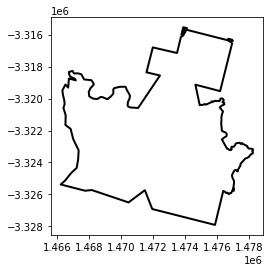

In [11]:
RamsarBoundary.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 2);

Interpolate the satellite observation onto the resolution of the high res LiDAR data

In [36]:
WetonLidar = AllDataCombined['wet'].isel(time=100).interp(x = HighResLidar.x, y= HighResLidar.y, method='nearest')

In [37]:
WetonLidar = np.isfinite(WetonLidar)

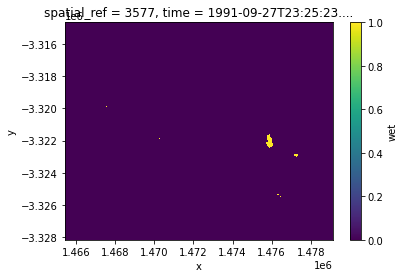

In [173]:
WetonLidar.plot()

In [38]:
WetPolygons = features.shapes(WetonLidar.data.astype('float32'),
                              transform=HighResLidar.attrs['transform'],
                             connectivity=8)

DiscreteWetPolygons = gpd.GeoDataFrame(WetPolygons, columns =['stringgeom', 'wetyes'])

DiscreteWetPolygons['geometry'] = None
for ix, poly in DiscreteWetPolygons.iterrows():
    DiscreteWetPolygons.loc[ix,'geometry'] = shapelyshape(poly[0])
    
# Set the geometry of the dataframe to be the shapely geometry we just created
DiscreteWetPolygons = DiscreteWetPolygons.set_geometry('geometry')
# We need to add the crs back onto the dataframe
DiscreteWetPolygons.crs = 'EPSG:3577'

# Drop the nan polygon created from the nan values
DiscreteWetPolygons = DiscreteWetPolygons.loc[DiscreteWetPolygons['wetyes'] == 1]

# And drop the stringgeom
DiscreteWetPolygons.drop('stringgeom', axis=1, inplace=True)

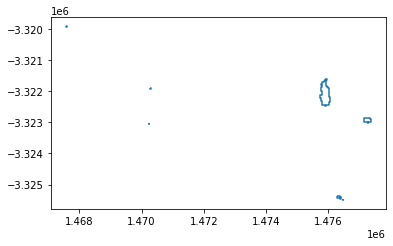

In [39]:
DiscreteWetPolygons.exterior.plot();

In [40]:
DiscreteWetPolygons.to_file('wettest.shp')

## Combine the wet polygons with the lidar data to generate a water surface

In [41]:
WetTimestep = gpd.read_file('wettest.shp')

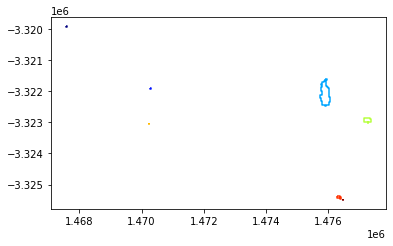

In [42]:
WetTimestep.exterior.plot(cmap='jet')

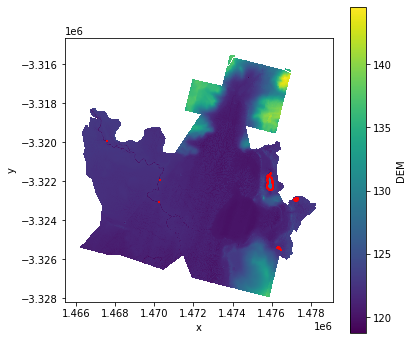

In [43]:
fig, ax = plt.subplots(1,1, figsize=[6, 6]);
HighResLidar.DEM.plot();
WetTimestep.plot(color=None, edgecolor='r', linewidth = 2, ax=ax);

In [164]:
for shapez in WetTimestep.iterrows():
    if shapez[0] == 2:
        EstWaterLevel = get_water_level(shapez[1]['geometry'], HighResLidar.DEM, x_offsets=range(-20,20,5), y_offsets=range(-20,20,5))
        EstWaterHeight = EstWaterLevel['water_level'] - HighResLidar.DEM
        EstWaterHeight.attrs['transform'] = HighResLidar.attrs['transform']
        y, x = HighResLidar.DEM.values.shape
        # Now convert the polgons into a numpy array
        RasterWetPoly = features.rasterize(shapes=shapez[1],
                                                out_shape=(y, x),
                                                all_touched=False,
                                                fill=np.nan,
                                                transform=HighResLidar.attrs['transform'])
        # Convert result to a xarray.DataArray using coords etc from the LiDAR data
        RasterWetPoly = xr.DataArray(RasterWetPoly,
                                 coords=[HighResLidar.y, HighResLidar.x],
                                 dims=['y', 'x'],
                                 name='wetBits',
                                 attrs=HighResLidar.attrs)
        WaterBodyHeight = EstWaterHeight.where((RasterWetPoly == 1) & (EstWaterHeight >= 0))
        break

/env/lib/python3.6/site-packages/rasterio/features.py:312: ShapeSkipWarning: Invalid or empty shape 1.0 at index 0 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)


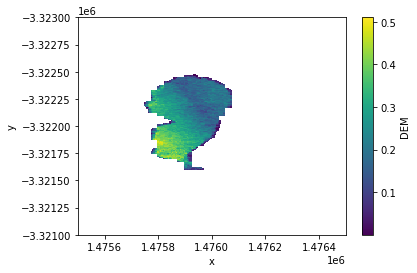

In [175]:
WaterBodyHeight.plot();
plt.xlim([1475500, 1476500]);
plt.ylim([-3321000, -3323000]);

In [140]:
shapez[1]

wetyes                                                      1
geometry    POLYGON ((1475897.058626372 -3321597.700310224...
Name: 2, dtype: object

/env/lib/python3.6/site-packages/rasterio/features.py:312: ShapeSkipWarning: Invalid or empty shape 1.0 at index 0 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)


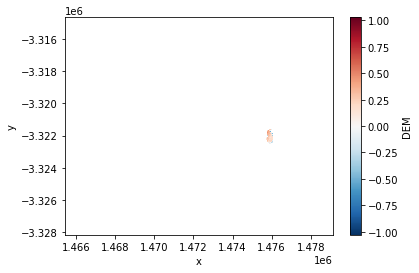

In [161]:
EstWaterHeight.where(RasterWetPoly == 1).plot()

In [76]:
def get_water_level(geom, dem, x_offsets=[0], y_offsets=[0]):  
        
    '''
    Takes a shapely geometry (either LineString or MultiLineString) and a Digital Elevation
    Model (DEM), and samples values from the DEM based on line vertices. These values are used
    to return the median and standard deviation of elevation, which can subsequently be used
    to compute volume (and uncertainty) based on the same DEM.
    
    Optionally, this function can be run with a set of x and y offset values, which shuffle 
    the geometry object left, right, up and down, and returns values for the combination 
    with the lowest standard deviation. This is intended to account for 'jitter' caused by 
    poor co-registration/georeferencing in the Sentinel 2 imagery. This is experimental, and
    should be used with caution.
    
    Last modified: March 2019
    Author: Robbi Bishop-Taylor
    
    Parameters
    ----------    
    geom : Shapely LineString or MultiLineString
        Shapely geometry for the waterline being analysed
    dem : array
        A 2D digital elevation model (DEM) in the form of a numpy or xarray array.
    x_offsets : list, optional
        A list giving a series of amounts in metre units to shuffle the geometry east and west.
        The default is [0], which does no shuffling. E.g. setting `x_offsets=[-10, 0, 10]`
        will shuffle the geometry west and east by 10 m, and return results for the offset which
        produces the lowest standard deviation in extracted elevation values.
    y_offsets : list, optional
        A list giving a series of amounts in metre units to shuffle the geometry north and south.
        The default is [0], which does no shuffling. E.g. setting `y_offsets=[-10, 0, 10]`
        will shuffle the geometry north and south by 10 m, and return results for the offset which
        produces the lowest standard deviation in extracted elevation values.
        
    Returns
    -------
    offset_min_std : Pandas DataFrame
        A Pandas dataframe with columns giving `x_offset', 'y_offset`, `water_level` and 
        `water_level_std` values. `x_offset', 'y_offset` give the offset values which resulted
        in the lowest standard deviation of elevation values, while `water_level` and 
        `water_level_std` return the corresponding median and standard deviation elevation values
        themselves.
    '''
    
    # First try extracting line vertex coordinates from a Shapely LineString
    try: 
        xx, yy = geom.exterior.coords.xy
        xx = np.array(xx)
        yy = np.array(yy)

    # If this fails, extract line vertex coordinates as if data is a Shapely MultiLineString
    except:

        xx = np.concatenate([i.coords.xy[0] for i in geom])
        yy = np.concatenate([i.coords.xy[1] for i in geom]) 
        
    # Convert coordinates to xarray DataArrays to facilitate fast extraction of elevation values
    xx = xr.DataArray(xx, dims='z')
    yy = xr.DataArray(yy, dims='z')
    
    # Iterate through all combinations of x and y offsets
    all_offsets = []    

    for x_offset, y_offset in itertools.product(x_offsets, y_offsets):        

        # Sample DEM to extract elevations for each vertex coordinate
        sampled_elevs = dem.interp(x=xx + x_offset, y=yy + y_offset).values

        # Compute median and standard deviation elevation values, and add to list
        all_offsets.append(((x_offset, y_offset, np.nanmedian(sampled_elevs), np.nanstd(sampled_elevs))))

    # From the dataframe of resulting water_levels and water_level_stds for different xy offsets, 
    # select the row with the lowest standard deviation in elevation values.
    offset_df = pd.DataFrame(all_offsets, columns=['x_offset', 'y_offset', 
                                                   'water_level', 'water_level_std'])
    offset_min_std = offset_df.iloc[offset_df.water_level_std.idxmin()]

    return offset_min_std 

In [78]:
WetTimestep.loc[[2], 'geometry']

2    POLYGON ((1475897.059 -3321597.700, 1475972.11...
Name: geometry, dtype: geometry

In [75]:
WetTimestep

,wetyes,geometry
0,1.0,"POLYGON ((1467575.760 -3319901.426, 1467600.77..."
1,1.0,"POLYGON ((1470277.806 -3321897.926, 1470302.82..."
2,1.0,"POLYGON ((1475897.059 -3321597.700, 1475972.11..."
3,1.0,"POLYGON ((1469777.427 -3322848.640, 1469802.44..."
4,1.0,"POLYGON ((1477198.043 -3322848.640, 1477323.13..."
5,1.0,"POLYGON ((1470227.768 -3323023.772, 1470252.78..."
6,1.0,"POLYGON ((1476297.362 -3325375.538, 1476397.43..."
7,1.0,"POLYGON ((1476472.494 -3325475.613, 1476497.51..."
